# <ins style="color : orange"> TP Report, by KHOUTAIBI Iliass and BARAKA Rayane</ins>

### <ins style="color : gold"> Introduction: </ins>

Bells are among the oldest music instruments and the sound they produce is often evocative because it has soothed the everyday life of generations for about 3000 years, accompanying minor and major events. 

This evocation is partly due to the structure of the sound spectrum: the eigenmodes of vibration are generally tuned by the bell makers so that their frequencies follow a particular series, which includes.

the minor third (E flat if the bell is tuned in C). This series is not harmonic, but the ratios between the eigenfrequencies are such that one can perceive a well-defined pitch. In particular, the presence of the series 2-3-4, strong at the beginning of the sound, reinforces the feeling of pitch in the neighborhood of the fundamental frequency. This feeling is related to a psychoacoustic effect (processing of the signal
received by the brain).

Let $f_p$ be the frequency corresponding to the perceived pitch. The analysis of the eigenfrequencies
series leads to a table of about 15 ratios $\alpha_n = \frac{f_n}{f_p}$. Their orders of magnitude are as follows: $0.5$ (hum
/ "bourdon"), $1$ (prime / fundamental), $1.2$ (minor third), $1.5$ (fifth), $2$ (nominal / octave), $2.5, 2.6, 2.7, 3,
3.3, 3.7, 4.2$ (wrong double octave), $4.5$, $5, 5.9$. The timbre of the corresponding sound depends on the
amplitude and on the decrease of each of these partials.



The TP down below aims to reconstruct the bell sounds using two prominent reconstruction methos:

$$\text{MUSIC and ESPRIT}$$

We first start by importing useful modules and writing function important for the reconstruction and for reading the soundfiles. 

In [159]:
import os, sys, wave, struct

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython

from copy import deepcopy
from math import ceil, exp, atan, pi, cos, sin
from scipy.io.wavfile import write
from scipy.linalg import hankel

import pylab as p
import mpl_toolkits.mplot3d.axes3d as p3

We define two function: $\text{load\_sound, plot\_sound} and read\_values$, which aim to load the soundfiles, plot the sound and to read the content of the sound file as well as its sampling rate $F_s$.

In [160]:
def load_sound(file):
    return wave.open(file, 'rb')

def plot_sound(data, times,xlim1,xlim2,name='default_name', save=False,w=20,h=10, lw = 3):
    plt.figure(figsize=(w, h))
    plt.plot(times,data.reshape(len(data)))
    plt.xlim(xlim1,xlim2)
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()
    
def read_values(filename):
    wave_file = wave.open(filename, 'r')
    nframes = wave_file.getnframes()
    nchannels = wave_file.getnchannels()
    sampling_frequency = wave_file.getframerate()
    T = nframes / float(sampling_frequency)
    read_frames = wave_file.readframes(nframes)
    wave_file.close()
    data = struct.unpack("%dh" %  nchannels*nframes, read_frames)
    
    data_per_channel = [data[offset::nchannels] for offset in range(nchannels)]
    return T, np.array(data_per_channel), nframes, nchannels, sampling_frequency

The function down below $\text{Synthesis}$ the signal under the hypothese that our signal $s(t)$ follows the $\text{Exponential Sinusoidal Model}$,

i.e $$ s[t] = \sum_{k=0}^{K-1}a_k e^{\delta_k t} e^{i(2\pi f_{k}t + \phi_{k})}$$

which to each frequency $f_k \in \left] -\frac{1}{2}, \frac{1}{2} \right]$ associates a real amplitude $a_k > 0$, a phase $\varphi_k \in \left] -\pi, \pi \right]$.

A damping factor $\delta_k \in \mathbb{R}$. By defining the complex amplitudes $\alpha_k = a_k e^{i\varphi_k}$ and the complex poles
$z_k = e^{\delta_k + i 2\pi f_k}$, this model can be rewritten in the form: 

$$s[t] = \sum_{k=0}^{K-1} \alpha_k z_k^t.$$

The function down below, implements the explained Model.

In [161]:
def Synthesis(N,delta,f,a,phi,RSB=False):
    t = range(N)
    logz = delta + 1j*2*np.pi*f
    alpha = a*np.exp(1j*phi)
    x = np.sum(np.outer(alpha, np.ones(N))*np.exp(np.outer(logz,t)), axis=0)
    if RSB == False: 
        s = x
    else: 
        Ex = np.real(np.sum(np.abs(x)**2))/N
        b = np.random.normal(size=N) + 1j*np.random.normal(size=N)
        Eb = np.real(np.sum(np.abs(b)**2))/N
        b = b*np.sqrt(Ex/Eb)*10**(-RSB/20)
        s = x+b    
    return s

Let us try opening the bell sound file and play it.

In [162]:
wavefile = load_sound('ClocheB.WAV')
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=8000, nframes=99414, comptype='NONE', compname='not compressed')


In [163]:
IPython.display.Audio('ClocheB.WAV')

Let us plot the sound file using the previously defined function.

In [164]:
T, data, nframes, nchannels, sampling_frequency = read_values('ClocheA.WAV')
Fs = int(wavefile.getframerate())
x = np.array(data)
num_samples = int(wavefile.getnframes())

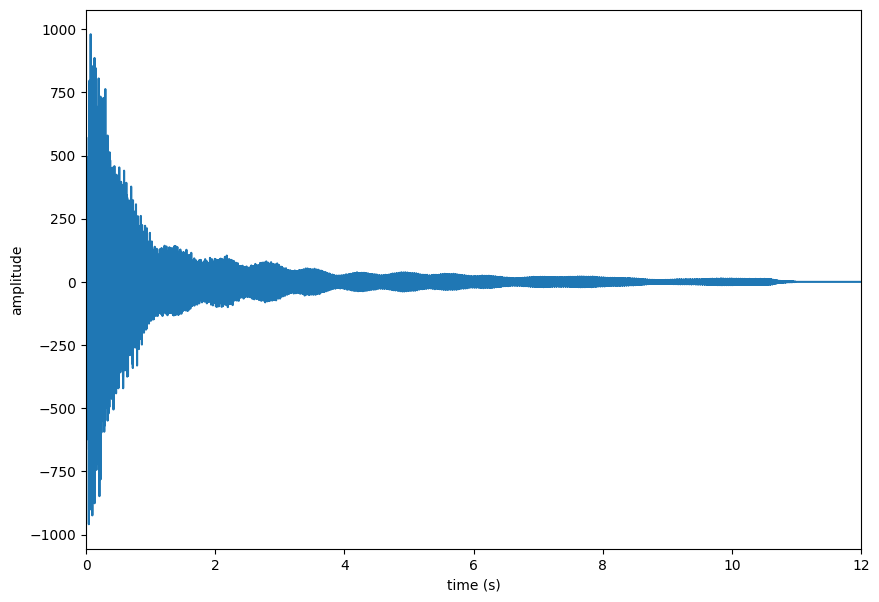

In [165]:
len_x = x.shape[1]
timestep = 1/(float(Fs))
times = np.arange(len_x)*timestep # int(len_x/6)
plot_sound(x.reshape(len_x), times,0,12,w=10,h=7)

We can also write into a new file using the $\text{write}$ method of scipy.

In [166]:
write('new_bell.wav', Fs, np.array(x.reshape(len_x), dtype=np.int16)) # to write a new wave file

### <ins>Synthetic Signal.</ins>

Here we consider a synthetic signal of length $N$, consisting of a sum of two complex exponentials, whose frequencies are separated by an interval $\Delta f = \frac{1}{N}$ (which corresponds to the resolution limit of Fourier analysis). The phases are drawn randomly, according to a uniform probability distribution on $(-\pi, \pi)$. 

We do not add noise to this signal, so that the observed signal $x[t]$ is equal to $s[t]$. You can use the following parameters: $N = 63$, $f_0 = \frac{1}{4}$, $f_1 = f_0 + \frac{1}{N}$, $a_0 = 1$, $a_1 = 10$, $\delta_0 = 0$, $\delta_1 = -0.05$.

In [167]:
#Init N at 63
N = 63

# define the constants f_0, f_1, a_0, a_1, delta_0 and finally delta_1 
f_0 = 1/4
f_signal = np.array([f_0, f_0 + 1/N], dtype=complex) #f_0, f_1
a = np.array([1, 10]) # a_0 , a_1
delta = np.array([0, -0.05]) #deltas
phi = np.random.uniform(-np.pi, np.pi, size=2) # phi_0, phi_1

print(f"The frequencies are: {f_signal}")
print(f"The deltas are: {delta}")
print(f"The a are: {a}")
print(f"The randomly selected phis are: {phi}")


x_signal = Synthesis(N, delta, f_signal, a, phi)

The frequencies are: [0.25      +0.j 0.26587302+0.j]
The deltas are: [ 0.   -0.05]
The a are: [ 1 10]
The randomly selected phis are: [-1.85392377 -1.53472658]


1. Observe the periodogram of this signal. Briefly study the separability of the two spectral lines, without zero-padding $(\text{Nfft} = N)$ and with zero-padding $(\text{Nfft} = 1024 \gt N)$.

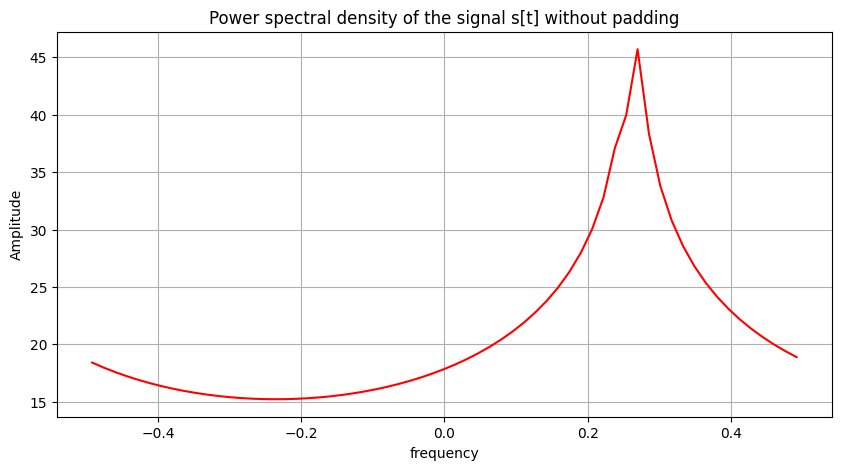

In [168]:
# Getting the FFT of the signal
FFT_x = np.fft.fft(x_signal, n=N)
FFT_x = np.fft.fftshift(FFT_x)
f = np.fft.fftfreq(N)
f = np.fft.fftshift(f)

# PLotting the results
plt.figure(figsize=(10, 5))
plt.title("Power spectral density of the signal s[t] without padding")
plt.plot(f, 10*np.log10(np.abs(FFT_x)**2), color="red")
plt.xlabel("frequency")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

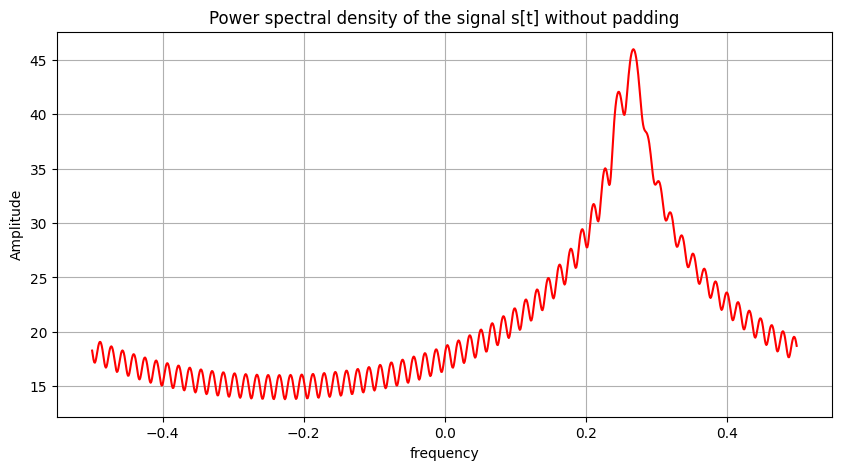

In [169]:
# using the Nfft padding 
FFT_x = np.fft.fft(x_signal, n=1024)
FFT_x = np.fft.fftshift(FFT_x)
f = np.fft.fftfreq(1024)
f = np.fft.fftshift(f)

plt.figure(figsize=(10, 5))
plt.plot(f, 10*np.log10(np.abs(FFT_x)**2), color="red")
plt.title("Power spectral density of the signal s[t] without padding")
plt.grid()
plt.xlabel("frequency")
plt.ylabel("Amplitude")
plt.show()

As we can see, the resolution using the Fourier Method is not great, it is difficult to find the peaks corresponding to the frquencies we wish to estimate.

For this, we can use the two methods introduced in the Introduction of this TP:

$$\text{Music and ESPRIT}$$

1. Computation of the empirical covariance matrix

The empirical covariance matrix of the observed signal is defined by the equation:
$$
\hat{R}_{xx} = \frac{1}{l} X X^H
$$  

where $X$ is an $ n \times l $ Hankel matrix containing the $N = n + l - 1$ samples of the signal:  

$$
X = 
\begin{bmatrix}
x[0] & x[1] & \cdots & x[l-1] \\
x[1] & x[2] & \cdots & x[l] \\
\vdots & \vdots & \ddots & \vdots \\
x[n-1] & x[n] & \cdots & x[N-1]
\end{bmatrix}
$$

Using the hankel function, we define the code below.

In [170]:
def empirical_covaraince(signal, n):
    N = len(signal)
    l = N - n + 1
    X = hankel(signal[0: n], signal[n-1: N])
    return (X @ X.conj().T) / l

2. Implementing the ESPRIT and LeastSqaures Methods

The code below implements the ESPRIT Method, as explained in the TP.

We begin by computing the **eigenvalue decomposition** of the Hankel matrix $X$:
$$
X = U_1 \Lambda U_2
$$

We construct the matrix $W$ by taking the **first two columns** of $U_1$.

Next, we define the matrices $W_{\downarrow}$ and $W_{\uparrow}$ as:
- $W_{\downarrow}$: the matrix obtained by removing the **first row** of $W$,
- $W_{\uparrow}$: the matrix obtained by removing the **last row** of $W$.

We compute the matrix:
$$
\Phi = W_{\downarrow}^{\dagger} W_{\uparrow}
$$
and extract its eigenvalues $z_1, \dots, z_n$, which are the **poles** of the polynomial we want to estimate.

For each $k$, define:
$$
\delta_k = \log(|z_k|), \quad f_k = \frac{\arg(z_k)}{2\pi}
$$

We then form the vectors:
$$
\delta = [\delta_1, \dots, \delta_n], \quad f = [f_1, \dots, f_n]
$$

Using a **least squares** approach, we construct the Vandermonde matrix $V^N \in \mathbb{C}^{N \times K}$ such that:
$$
\ln(V_{t,k}^N) = t(\delta_k + i 2\pi f_k)
$$

We then compute:
$$
\alpha = (V^N)^{\dagger} x
$$
with $x = [x[0], \dots, x[N-1]]$.  

By computing the magnitude and phase of each coefficient of $\alpha$, we obtain estimates of the amplitudes and phases originally set in the signal.


In [171]:
def Esprit(x, n, K):

    R_xx = empirical_covaraince(x, n)
    U, _, _ = np.linalg.svd(R_xx)
    W = U[:, :K]
    W_down = W[: -1, :]
    W_up = W[1 :, :]
    phi_Matrix = np.linalg.pinv(W_down) @ W_up
    eingen_values = np.linalg.eigvals(phi_Matrix)
    
    delta_empirical = np.log(np.abs(eingen_values))
    f_empirical =  np.angle(eingen_values) / (2 * np.pi)

    return delta_empirical, f_empirical


def LeastSquares(x, delta, f):

    t = np.arange(x.shape[0]).reshape(-1, 1)
    exponent = delta + 2j * np.pi * f
    ln_V_N = t @ exponent.reshape(1, -1)
    
    V_n = np.exp(ln_V_N)
    V_n_inverse = np.linalg.pinv(V_n)

    alpha = V_n_inverse @ x
    a_empirical = np.abs(alpha)
    phi_empirical = np.angle(alpha) 

    return a_empirical, phi_empirical

Let us apply the above methods to reconstruct our signal !

In [172]:
delta_empirical, f_empirical = Esprit(x_signal, 32, 2)
a_empirical, phi_empirical = LeastSquares(x_signal, delta_empirical, f_empirical)

print(f"delta are: {delta_empirical}, f are: {f_empirical}, a are: {a_empirical} and phis are: {phi_empirical}")    

delta are: [-0.05  0.  ], f are: [0.26587302 0.25      ], a are: [10.  1.] and phis are: [-1.53472658 -1.85392377]


As we can see, we get a very great approximate of our variables as defined above ! The $\text{ESPRIT}$ method then is a great way to approximate the parameters of the sinusoidal signal.

3. MUSIC method

We define the function $\text{MUSIC(x, n, K)}$ which computes and plots the logarithm of the pseudo-spectrum as a function of two variables:
$f \in [0, 1] \quad \text{and} \quad \delta \in [-0.1, 0.1]$.

We then apply the function $\text{MUSIC}$ to the previously synthesized signal, and verify that the pseudo-spectrum clearly reveals the two poles:
$
z_k = e^{\delta_k + i 2\pi f_k}
$
The peaks in the pseudo-spectrum correspond to the positions of the poles in the $(\delta, f)$ plane, indicating the components present in the signal.


The function down below implemnts the Music Method and plots the results.

In [173]:
def Music(x, n, K):
    
    R_xx = empirical_covaraince(x, n)
    
    U, S, V = np.linalg.svd(R_xx)
    W_T = U[:, K:]
    
    f_vals = np.linspace(0, 1, 150)
    delta_vals = np.linspace(-0.1, 0.1, 100)
    f_grid, delta_grid = np.meshgrid(f_vals, delta_vals)
    
    result = np.zeros_like(f_grid)

    for i in range(f_grid.shape[0]):
        for j in range(f_grid.shape[1]):
            f = f_grid[i, j]
            delta = delta_grid[i, j]
            v = np.exp(
                np.arange(n).T*(delta + 1j*2*np.pi*f)
            )
            result[i, j] = 1 / (np.linalg.norm(W_T.conj().T @ v)**2)

    
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot()
    surf = ax.pcolormesh(delta_grid, f_grid, result, cmap='magma')
    fig.colorbar(surf, ax=ax, shrink=0.6, aspect=12, label="Abs")
    ax.set_xlabel('delta')
    ax.set_ylabel('frequency')
    ax.set_ylim(0.1, 0.4)
    ax.set_xlim(-0.075, 0.075)
    plt.title('MUSIC Spectrum')
    plt.show()

Let us now apply the $\text{MUSIC}$ method to our signal to estimate the values.

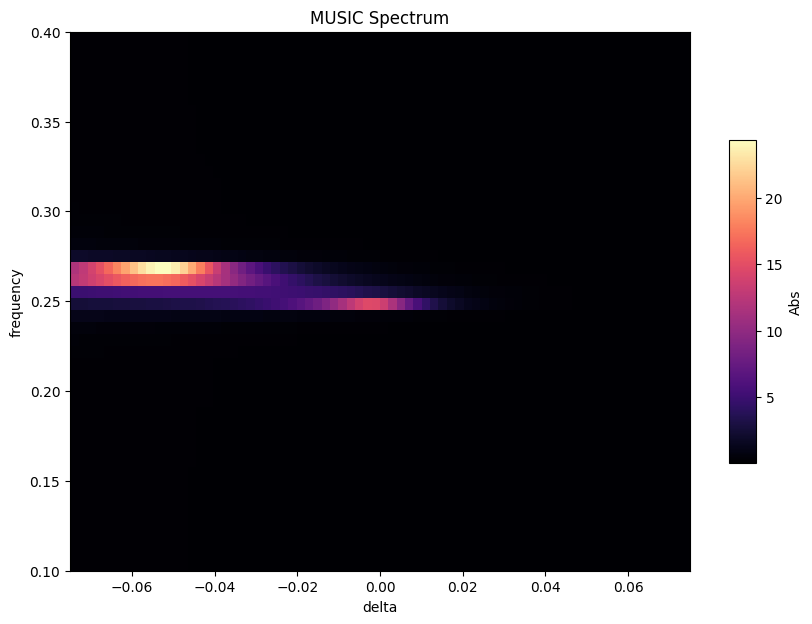

In [174]:
Music(x_signal, n=32, K=2)

As we can see, we have peaks for $f = 0.25$ and $f \approx 0.26$. We also find $\delta = -0.05$ and $\delta \approx 0$.

The $\text{MUSIC}$ method then helps estimate our parameters.

4. We now want to apply the ESPRIT method to this signal.

Let $K = 54$, $n = 512$, and $l = 2n = 1024$.

In order to guarantee that the signal model holds on the analysis window (exponential damping), we will extract a segment of length $N$ whose beginning is posterior to the maximum of the waveform envelope. 


We first need to read our audio files using the previouslt defined functions.

In [175]:
# Reading the Wave File Cloche A
wavefile = load_sound('ClocheA.WAV')
T, data_a, nframes, nchannels, sampling_frequency = read_values('ClocheA.WAV')
Fs_A = int(wavefile.getframerate())
bell_a = np.array(data_a).flatten()
num_samples_A = int(wavefile.getnframes())


# Rading the wavefile Cloche B
wavefile = load_sound('ClocheB.WAV')
T, data_b, nframes, nchannels, sampling_frequency = read_values('ClocheB.WAV')
Fs_B = int(wavefile.getframerate())
bell_b = np.array(data_b).flatten()
num_samples_B = int(wavefile.getnframes())

Let us plot the Power Spectral Density of our signal.

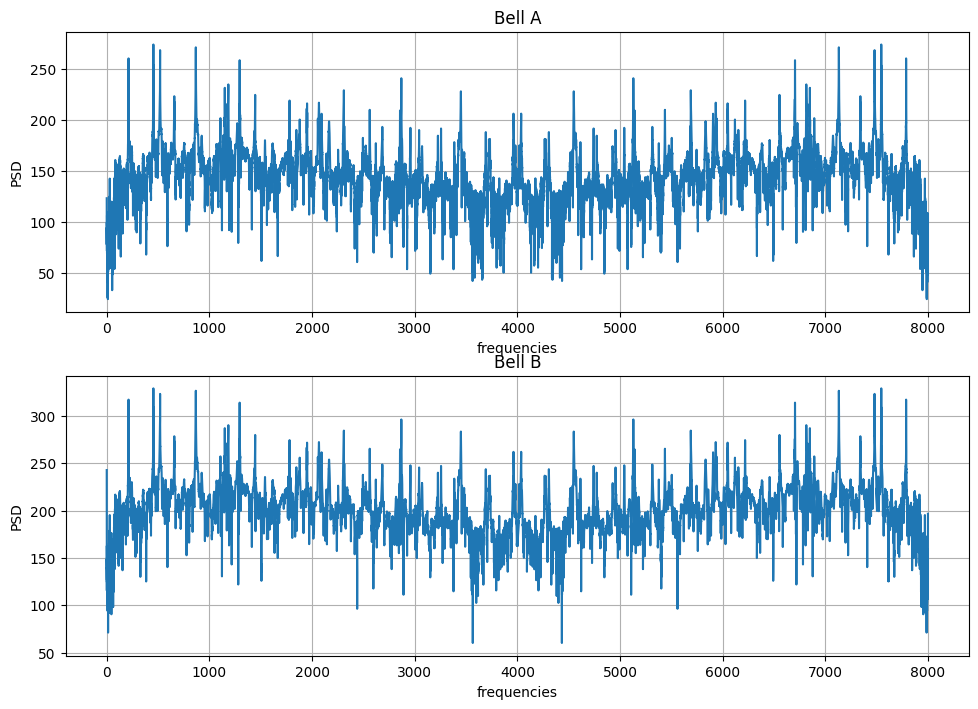

In [176]:
# Getting the Power spectral Densities of our bells
periodogram_A = np.abs(np.fft.fft(bell_a))**2
periodogram_B = np.abs(np.fft.fft(bell_b))**2


# plotting the results
plt.figure(figsize=(10,7))
plt.tight_layout()
plt.subplot(2,1,1)
plt.plot(np.linspace(0,Fs_A,len(bell_a)), 10*np.log(periodogram_A))
plt.xlabel("frequencies")
plt.ylabel("PSD")
plt.grid()
plt.title('Bell A')

plt.subplot(2,1,2)
plt.tight_layout()
plt.plot(np.linspace(0,Fs_B,len(bell_b)), 10*np.log(periodogram_B))
plt.title('Bell B')
plt.xlabel("frequencies")
plt.ylabel("PSD")
plt.grid()
plt.show()

Let us reconstruct the signal and take $N = 4 \times \text{Fs\_A}$.

Note: Taking the values proposed by the TP will cause the signal to diverge! Test and see for yourself!

In [177]:
# Parameters as asked in the question
K = 54
n = 512
l = 1024
N = 4 * Fs_A

# Reconstruction of the signals A and B

bell_A = bell_a[1_000: 1_000 + N]
bell_B = bell_b[10_000: 10_000 + N]

# Getting the parameters of the signals
delta_bell_A, f_bell_A = Esprit(bell_A, n, K)
a_empirical_A, phi_empirical_A = LeastSquares(bell_A, delta_bell_A, f_bell_A)

delta_bell_B, f_bell_B, = Esprit(bell_B, n, K) 
a_empirical_B, phi_empirical_B = LeastSquares(bell_B, delta_bell_B, f_bell_B)

In [178]:
# Reconstructing the signal
synthesised_signal_A = Synthesis(N, delta_bell_A, f_bell_A, a_empirical_A, phi_empirical_A)
synthesised_signal_B = Synthesis(N, delta_bell_B, f_bell_B, a_empirical_B, phi_empirical_B)

Let us plot the $\text{PSD}$ of the real signal and the reconstructed one to compare. Let us also play the sounds.

Let us start with the signal $\text{ClocheA}$.

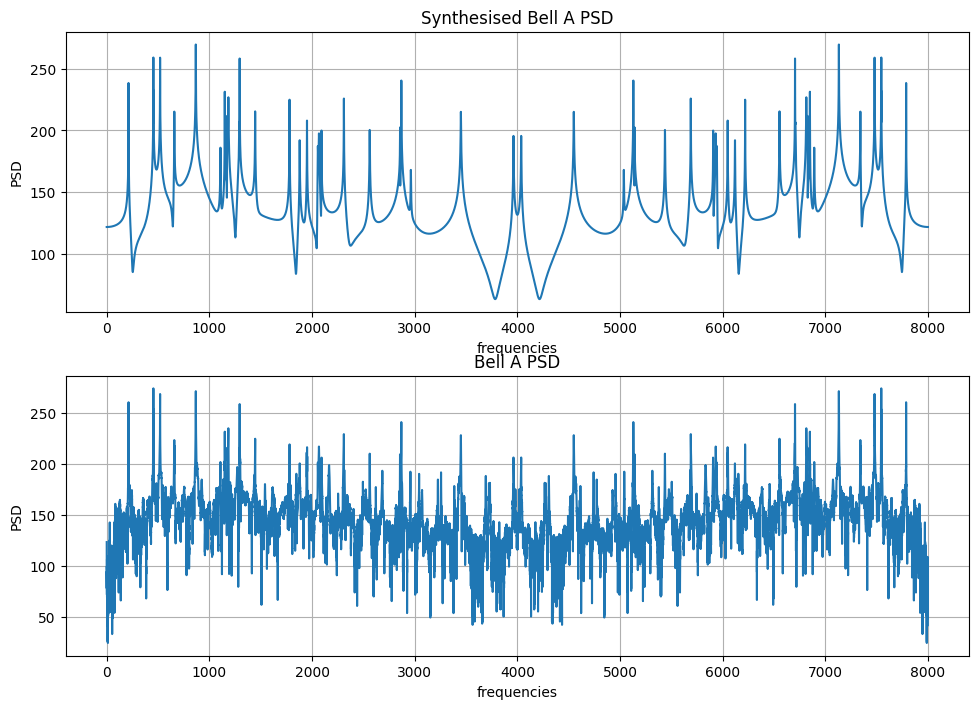

In [179]:
# Getting the periodogram of A
periodogram_synthesised_A = np.abs(np.fft.fft(synthesised_signal_A))**2

# plotting the results
plt.figure(figsize=(10,7))
plt.tight_layout()
plt.subplot(2,1,1)
plt.plot(np.linspace(0, Fs_A, len(synthesised_signal_A)), 10*np.log(periodogram_synthesised_A))
plt.xlabel("frequencies")
plt.ylabel("PSD")
plt.title('Synthesised Bell A PSD')
plt.grid()

plt.subplot(2,1,2)
plt.tight_layout()
plt.plot(np.linspace(0, Fs_A, len(bell_a)), 10*np.log(periodogram_A))
plt.title('Bell A PSD')
plt.xlabel("frequencies")
plt.ylabel("PSD")
plt.grid()
plt.show()

As we can see, from the synthesised signal, we find the fundemental frequencies of $\text{ClocheA}$'s Power Spectral Density.

Let us play the sounds to compare

In [180]:
write('bell_A.wav', Fs_A, np.array(np.real(synthesised_signal_A), dtype=np.int16))

In [181]:
# Synthesised Signal
IPython.display.Audio("bell_A.wav")

In [182]:
# Real Signal
IPython.display.Audio("ClocheA.WAV")

Great! We have something that closely matches the dings and dangs of our bell A! Let us now synthesise the signal of bell B.

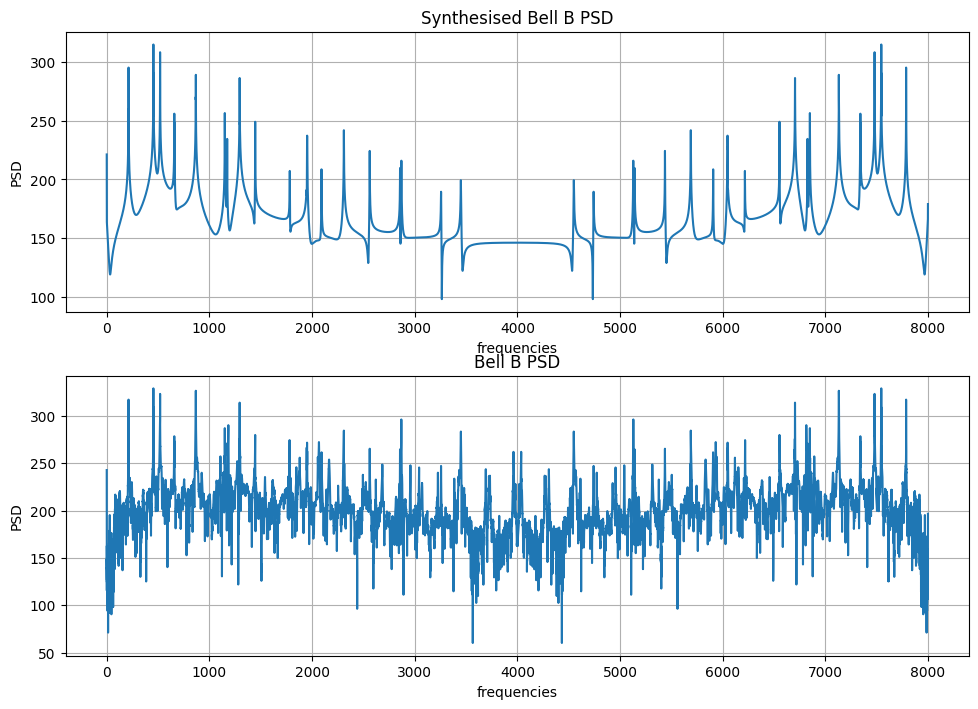

In [183]:
# Getting the periodogram of A
periodogram_synthesised_B = np.abs(np.fft.fft(synthesised_signal_B))**2

# plotting the results
plt.figure(figsize=(10,7))
plt.tight_layout()
plt.subplot(2,1,1)
plt.plot(np.linspace(0, Fs_B, len(synthesised_signal_B)), 10*np.log(periodogram_synthesised_B))
plt.xlabel("frequencies")
plt.ylabel("PSD")
plt.title('Synthesised Bell B PSD')
plt.grid()

plt.subplot(2,1,2)
plt.tight_layout()
plt.plot(np.linspace(0,  Fs_B, len(bell_b)), 10*np.log(periodogram_B))
plt.title('Bell B PSD')
plt.xlabel("frequencies")
plt.ylabel("PSD")
plt.grid()
plt.show()

As we can see, from the synthesised signal, we find the fundemental frequencies of $\text{ClocheB}$'s Power Spectral Density.

Let us play the sounds to compare

In [184]:
write('bell_B.wav', Fs_B, np.array(np.real(synthesised_signal_B), dtype=np.int16))

In [185]:
# Playing the reconstructed signal of Cloche B
IPython.display.Audio("bell_B.wav")

In [186]:
# Playing the sound of the real ClocheB signal
IPython.display.Audio("ClocheB.WAV")

### <ins style="color : green">Conclusion</ins>

From this TP, we have learned methods to synthesise a particular type of music signals using both: $\text{MUSIC and ESPRiT}$. With these implementations, we have succeeded in reconstructing a bell signals that closely matches the real ones! 